In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import imutils
import time
from bspline_path import  approximate_b_spline_path
from cubic_spline_planner import  Spline2D

from scipy import ndimage
from skimage.measure import  label
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis

In [2]:
lane_dir = '/home/ivslab/DriveImage/pred_lane/'
main_dir = '/home/ivslab/DriveImage/pred_main/'

In [3]:
# base_point = (1024//2 + 20,575)
# VERTICAL_CROP = 500
# mask = plt.imread('mask.jpg').copy()
# mask[mask>0] = 1

# segment = 5
# horizon = 350

In [4]:
"""

Path planning with Bezier curve.

author: Atsushi Sakai(@Atsushi_twi)

"""

import scipy.special

show_animation = True

        
def adjust_gamma(image, gamma=0.8):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    image = np.power(image/255.0, gamma)
    return (image * 255.0).astype(np.uint8)
    

In [5]:
from bspline_path import  approximate_b_spline_path
from sklearn import linear_model, datasets

In [6]:
def calc_4points_bezier_path(sx, sy, syaw, ex, ey, eyaw, offset):
    """
    Compute control points and path given start and end position.

    :param sx: (float) x-coordinate of the starting point
    :param sy: (float) y-coordinate of the starting point
    :param syaw: (float) yaw angle at start
    :param ex: (float) x-coordinate of the ending point
    :param ey: (float) y-coordinate of the ending point
    :param eyaw: (float) yaw angle at the end
    :param offset: (float)
    :return: (numpy array, numpy array)
    """
    dist = np.hypot(sx - ex, sy - ey) / offset
    control_points = np.array(
        [[sx, sy],
         [sx + dist * np.cos(syaw), sy + dist * np.sin(syaw)],
         [ex - dist * np.cos(eyaw), ey - dist * np.sin(eyaw)],
         [ex, ey]])

    path = calc_bezier_path(control_points, n_points=100)

    return path, control_points


def calc_bezier_path(control_points, n_points=100):
    """
    Compute bezier path (trajectory) given control points.

    :param control_points: (numpy array)
    :param n_points: (int) number of points in the trajectory
    :return: (numpy array)
    """
    traj = []
    for t in np.linspace(0, 1, n_points):
        traj.append(bezier(t, control_points))

    return np.array(traj)


def bernstein_poly(n, i, t):
    """
    Bernstein polynom.

    :param n: (int) polynom degree
    :param i: (int)
    :param t: (float)
    :return: (float)
    """
    return scipy.special.comb(n, i) * t ** i * (1 - t) ** (n - i)


def bezier(t, control_points):
    """
    Return one point on the bezier curve.

    :param t: (float) number in [0, 1]
    :param control_points: (numpy array)
    :return: (numpy array) Coordinates of the point
    """
    n = len(control_points) - 1
    return np.sum([bernstein_poly(n, i, t) * control_points[i] for i in range(n + 1)], axis=0)


def bezier_derivatives_control_points(control_points, n_derivatives):
    """
    Compute control points of the successive derivatives of a given bezier curve.

    A derivative of a bezier curve is a bezier curve.
    See https://pomax.github.io/bezierinfo/#derivatives
    for detailed explanations

    :param control_points: (numpy array)
    :param n_derivatives: (int)
    e.g., n_derivatives=2 -> compute control points for first and second derivatives
    :return: ([numpy array])
    """
    w = {0: control_points}
    for i in range(n_derivatives):
        n = len(w[i])
        w[i + 1] = np.array([(n - 1) * (w[i][j + 1] - w[i][j])
                             for j in range(n - 1)])
    return w


def curvature(dx, dy, ddx, ddy):
    """
    Compute curvature at one point given first and second derivatives.

    :param dx: (float) First derivative along x axis
    :param dy: (float)
    :param ddx: (float) Second derivative along x axis
    :param ddy: (float)
    :return: (float)
    """
    return (dx * ddy - dy * ddx) / (dx ** 2 + dy ** 2) ** (3 / 2)


def plot_arrow(x, y, yaw, length=1.0, width=0.5, fc="r", ec="k"):  # pragma: no cover
    """Plot arrow."""
    if not isinstance(x, float):
        for (ix, iy, iyaw) in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * np.cos(yaw), length * np.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)

Image21


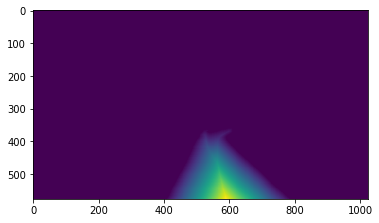

(576, 1024)
0.383387804031


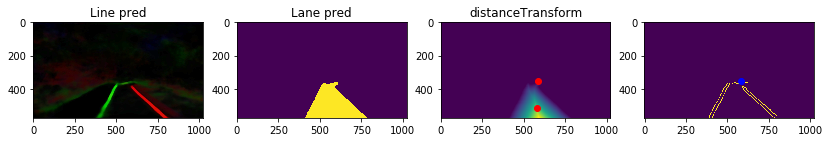

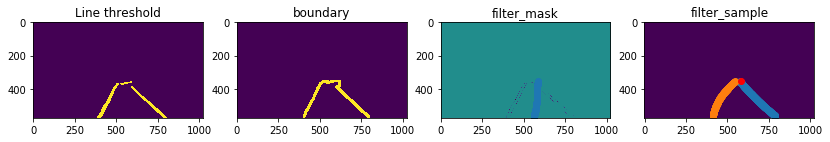

Image22


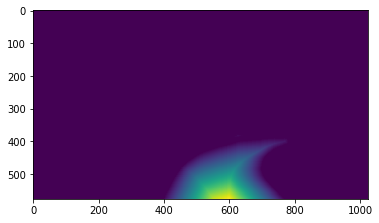

(576, 1024)
0.393144845963


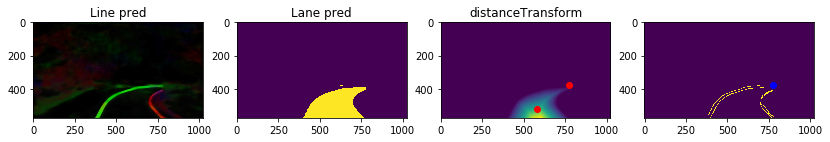

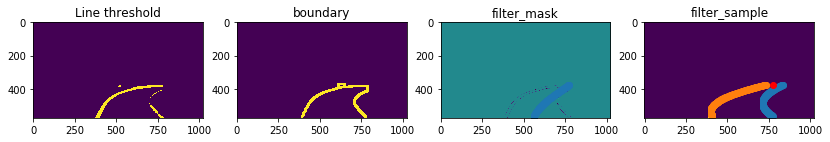

Image23


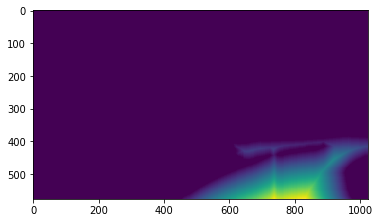

(576, 1024)
0.333647012711


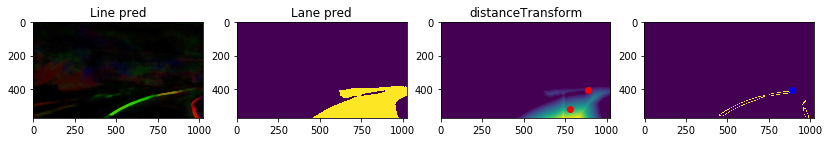

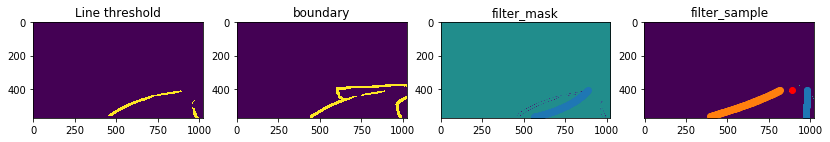

Image24


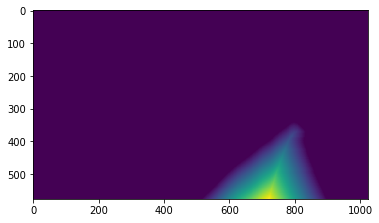

(576, 1024)
0.341814041138


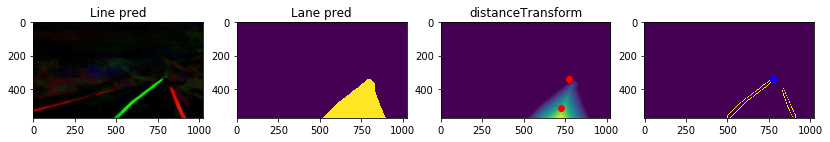

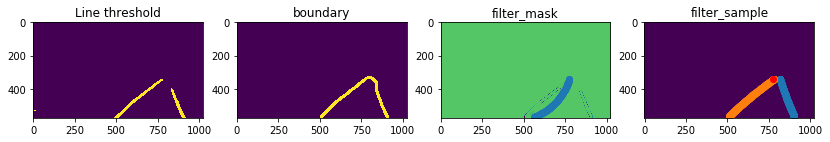

Image25


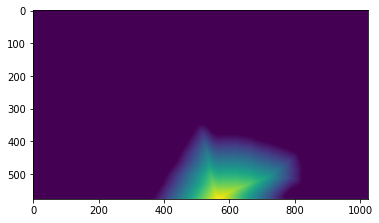

(576, 1024)
0.411982059479


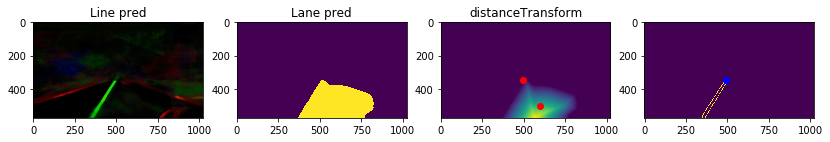

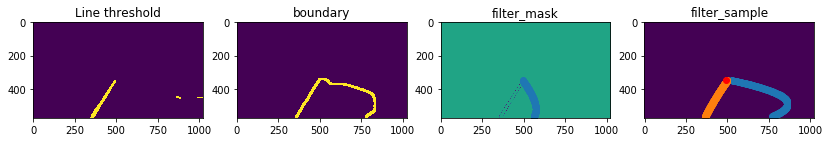

Image26


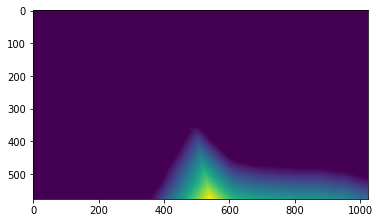

(576, 1024)
0.33585190773


KeyboardInterrupt: 

In [15]:



for i in range(21,150):
    
    # Read Image & Convert 
    
    print("Image{}".format(i))
    pred_lane = cv2.imread(os.path.join(lane_dir,'{}.jpg'.format(i)))
    pred_lane = adjust_gamma(pred_lane)
    pred_main = cv2.imread(os.path.join(main_dir,'{}.jpg'.format(i)))
    pred_lane_gray = cv2.cvtColor(pred_lane,cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((30,30),np.uint8)  
    height ,width ,channel=  pred_lane.shape
    # predict class
    start = time.time()
    
#     skeleton = skeletonize(pred_lane_gray)
#     plt.imshow(skeleton)
    

    
    # Otsu's thresholding after Gaussian filtering ------------

    ret3,main_mask = cv2.threshold(pred_main[:,:,1],0,255,cv2.THRESH_OTSU)
    dist_main_mask = cv2.distanceTransform(main_mask*pred_main[:,:,1],cv2.DIST_L1, 5)
    
    
    # Center of mass from distanceTransform -------------------
    center_mass = ndimage.measurements.center_of_mass(dist_main_mask)
    center_main_x,center_main_y = center_mass[1],center_mass[0]
    
    
    # Boundary caculate ---------------------------------------
    # Find line point from boundary of drive area
    
    main_mask_dilate = cv2.dilate(main_mask.copy(),kernel)
#     pred_lane_gray = cv2.medianBlur(pred_lane_gray,11)
#     pred_lane_gray = cv2.GaussianBlur(pred_lane_gray,(11,11),0)
    ret3,pred_lane_bin = cv2.threshold(pred_lane_gray,0,255,cv2.THRESH_OTSU)
    
    
    skel, distance = medial_axis(dist_main_mask, return_distance=True,mask=main_mask.astype(bool))
    dist_on_skel = distance * skel
    plt.imshow(dist_main_mask)
    plt.show()
    
    print(skel.shape)
#     skeleton = skeletonize(np.clip(main_mask,0,1))
    boundary = main_mask_dilate-main_mask 
    filter_mask = np.logical_and(boundary,pred_lane_bin)
    
   
    

    

    # Corner Detect ---------------------------------------
    dst_original  = cv2.cornerHarris(filter_mask.astype(np.float32),2,3,0.1)
    dst = dst_original.copy()

    # Top K corner caculate ---------------------------------------
    dst_corner_y = np.where(abs(dst)>0)[0][:5].mean()
    dst_corner_x = np.where(abs(dst)>0)[1][:5].mean()
    # Linear Binary classifier -------------------------
    
    
    c = np.polyfit([dst_corner_y,center_main_y],[dst_corner_x,center_main_x],1)
    poly = np.poly1d(c)
    
    
    
    
    
    

    
    
    
    # Resample method -----------------------------
    index = np.array(np.arange(pred_lane_gray.shape[0]*pred_lane_gray.shape[1]))
    sample = np.zeros(pred_lane_gray.shape).flatten()
    p_left = (pred_lane[:,:,0].flatten().astype(float)/pred_lane[:,:,0].sum())
    p_right = (pred_lane[:,:,2].flatten().astype(float)/pred_lane[:,:,2].sum())


    ss_left = np.random.choice(index,(576//8,1024//8),replace=False,p=p_left)
    ss_right = np.random.choice(index,(576//8,1024//8),replace=False,p=p_right)

    sample[ss_left] = 255
    sample[ss_right] = 255
    sample = sample.reshape(pred_lane_gray.shape)
    filter_sample = np.logical_and(sample,boundary)*1
    
    
    
    # Classifier Liner  -----------------------------
    Y,X = np.nonzero(filter_sample)
    x_predict = poly(Y)
    line_class = X - x_predict
    line_class[line_class>=0] = 1
    line_class[line_class<=0] = 2
    filter_sample[Y,X] = line_class

    stop = time.time()
    
    # Fit line using all data  -----------------------------
#     lr = linear_model.LinearRegression()
#     lr.fit(X, Y)
    
    
#     # Robustly fit linear model with RANSAC algorithm
#     ransac = linear_model.RANSACRegressor()
#     ransac.fit(X, Y)
#     inlier_mask = ransac.inlier_mask_
#     outlier_mask = np.logical_not(inlier_mask)

    y = np.arange(int(dst_corner_y),height-10)

    left_y,left_x = np.where(filter_sample==1)
    c_left = np.polyfit(left_y,left_x,2)
    poly_left = np.poly1d(c_left)
    left_x = poly_left(y)
    left_x = np.clip(left_x,0,width)
    
    right_y,right_x = np.where(filter_sample==2)
    c_right = np.polyfit(right_y,right_x,2)
    poly_right = np.poly1d(c_right)
    right_x = poly_right(y)
    right_x = np.clip(right_x,0,width-10)
    
    
    
    
    
    print(stop-start)

    # -----------------
    """Plot an example bezier curve."""
    start_x = float(560.)  # [m]
    start_y = float(570.)  # [m]
    
    diff = (center_main_x-start_x,center_main_y-start_y)
    angle = np.angle([diff[0]+diff[1]*1j])[0]
    start_yaw = angle  # [rad]

    
    
    end_x = float(dst_corner_x)  # [m]
    end_y = float(dst_corner_y)  # [m]
    
    diff = (end_x - center_main_x,end_y - center_main_y)
    angle_ = np.angle([diff[0]+diff[1]*1j])[0]
    end_yaw = angle_  # [rad]
    offset = 3.0
    
    
    path, control_points = calc_4points_bezier_path(
        start_x, start_y, start_yaw, end_x, end_y, end_yaw, offset)
        
    
    f,ax = plt.subplots(1,4,figsize=(14,12))
    ax[0].imshow(pred_lane[...,::-1])
    ax[0].set_title("Line pred")
    ax[1].imshow(main_mask)
    ax[1].set_title("Lane pred")
    ax[2].imshow(dist_main_mask)
    ax[2].plot([center_main_x], [center_main_y], '-or', label="way points")
    ax[2].plot([dst_corner_x], [dst_corner_y], '-or', label="way points")
    ax[2].set_title("distanceTransform")
    ax[3].imshow(abs(dst)>0)
    ax[3].plot(dst_corner_x, dst_corner_y.astype(int), '-ob', label="way points")
    plt.show()
    
    
    f,ax = plt.subplots(1,4,figsize=(14,12))
    ax[0].imshow(pred_lane_bin)
    ax[0].set_title("Line threshold")
    ax[1].imshow(boundary)
    ax[1].set_title("boundary")
    ax[2].imshow(dst_original)
    ax[2].scatter(path[:,0], path[:,1])

    ax[2].set_title("filter_mask")
    ax[3].imshow(filter_sample)
    ax[3].set_title("filter_sample")
    ax[3].plot([dst_corner_x], [dst_corner_y], '-or', label="way points")
    ax[3].scatter(left_x.astype(int), y)
    ax[3].scatter(right_x.astype(int), y)
    plt.show()
    





In [12]:
path[]

array([[560.        , 570.        ],
       [563.5923452 , 569.17953677],
       [567.18832939, 568.3472491 ],
       [570.7876574 , 567.5029941 ],
       [574.3900341 , 566.64662887],
       [577.99516431, 565.7780105 ],
       [581.60275288, 564.8969961 ],
       [585.21250466, 564.00344276],
       [588.8241245 , 563.09720759],
       [592.43731723, 562.17814768],
       [596.0517877 , 561.24612013],
       [599.66724075, 560.30098205],
       [603.28338123, 559.34259052],
       [606.89991399, 558.37080266],
       [610.51654386, 557.38547556],
       [614.13297569, 556.38646632],
       [617.74891432, 555.37363203],
       [621.36406461, 554.34682981],
       [624.97813139, 553.30591674],
       [628.5908195 , 552.25074993],
       [632.2018338 , 551.18118648],
       [635.81087912, 550.09708349],
       [639.41766032, 548.99829804],
       [643.02188222, 547.88468726],
       [646.62324969, 546.75610823],
       [650.22146755, 545.61241805],
       [653.81624067, 544.45347382],
 

In [ ]:
dst_corner_y

In [ ]:
right_x

In [ ]:
p.shape